<h3><center>Kalman Filter Analysis<br>
CUNY SPS MSDS<br>
Professor Samuel Gralnick<br>
Team Sugar Cane: Euclid Zhang, Jie Zou, Zhenni Xie<br>
Fall 2022</center></h3>

In this analysis, we use the Kalman Filter to estimate the values of the assets in our investment portfolio. 

<br> 

We make the following assumptions in our analysis:
- The asset value follows a Brownian motion. That is, the daily change of the value is normally distributed with expected value 0.
- People's estimation of the true asset value is normally distributed with expected value approximately the same as the true asset value.
- The true asset value doesn't change through the same day. So the trading prices on the same day are the estimations of the same asset value by different traders.

Based on the assumptions, we have the following Predictor Equation and Measurement Equation:  
$ x_{t+1} = x_{t}+\epsilon_{x,t+1} $ where $\epsilon_{x,t+1}$ is normally distributed with variance Q  
$ z_{t} =  x_{t}+\epsilon_{z,t+1} $ where $\epsilon_{z,t+1}$ is normally distributed with variance R
  
 <br> 
  
We define the terms in the Kalman Filter as following:
- State (**x**): The true asset value. This is not the trading price of the asset. In real time transactions, people are estimating the value of the same asset differently and hence the trading price may differ from the true asset value.
- Measurement (**z**): We will use the daily VWAP (volume weighted average price) as the measurement or observation instead of the daily closing price. The daily closing price is just the trading price of the last transaction of the day and so it doesn't reflect the true state of the asset.
- Process Noise Uncertainty (**Q**): The random effect on the change of the state (asset value). Assume that the asset value follows a Brownian motion. The change of the asset value is normally distributed with expected value 0 with a variance Q.
- Measurement Uncertainty (**R**): The variance of the measurement error. In this case, the error is the amount of mispricing of the true asset value, which is *trading price - true asset value*. We assume this error is normally distributed with expected value 0 and variance R.

Since we use the VWAP as the measurement of the asset value, we can estimate Q using the volume weighted variance of *typical price - VWAP*, where the typical price = (1/3)*(high + low + close) as it is calculated in the VWAP calculation.   
For R, we can estimate it using the variance of the percent change of the daily VWAP.

The *pykalman* package in python can be used to perform the Kalman Filter calculation. However, the Process Noise Uncertainty (Q) and Measurement Uncertainty (R) are fixed and determined before the calculation. We would like the values of Q and R to be dynamic, which change based on the predicted value in each iteration. It is reasonable that a person misprices an asset by 10 when the price is 200. However, it is unreasonable that a person misprices an asset by 10 when the price is 20. Therefore, we construct our own Kalman Filter calculation and update Q and R in each iteration. 

In [133]:
# loading packages

import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
import scipy.stats as stats
import math
from statsmodels.stats.weightstats import DescrStatsW
import matplotlib.pyplot as plt
import pickle 
# from pykalman import KalmanFilter

In [134]:


start = datetime.strptime('2021-10-08', '%Y-%m-%d')
end = datetime.strptime('2022-10-08', '%Y-%m-%d')

In [135]:
# loading assets information

assets = pd.read_csv("portfolio assets.csv")
# assets

In [136]:
# retrieve the asset prices for the last 60 days, with interval 5 minutes

yf.pdr_override()

tickers = list(assets['Ticker'])[1:]

new_historical_data = pdr.DataReader(tickers, data_source='yahoo',period="60d",interval='5m')

# historical_data = historical_data.reset_index()
# historical_data.Date = historical_data.Date.apply(datetime.date)
# historical_data.set_index('Date', inplace = True)

[*********************100%***********************]  29 of 29 completed


In [137]:
# Save the asset prices. Yahoo only has the 5-m data for 60 days, so it is better to save the data now for later use.

file_data = open("price-5m-" + datetime.now().strftime("%m-%d-%Y") + ".pkl", 'wb') 
pickle.dump(new_historical_data, file_data)

In [138]:
# Load the asset prices that are previously saved

file_data = open("price-5m-10-22-2022.pkl", 'rb') 
historical_data = pickle.load(file_data)

In [139]:
# Impute missing prices using linear interpolation

pd.set_option('mode.chained_assignment', None)
historical_data['Adj Close'].interpolate(inplace=True)
historical_data['High'].interpolate(inplace=True)
historical_data['Low'].interpolate(inplace=True)
historical_data['Close'].interpolate(inplace=True)
historical_data['Volume'].fillna(0, inplace = True)

In [140]:
# Calculate the VWAP (Volume Weighted Average Price)

typical_price = (historical_data['High'] + historical_data['Low'] + historical_data['Close'])/3
total_traded = typical_price*historical_data['Volume']
total_traded.fillna(0, inplace = True)
VWAP = total_traded.groupby(total_traded.index.date).sum() / historical_data['Volume'].groupby(historical_data['Volume'].index.date).sum().replace(0,1)
VWAP = VWAP.replace(0, np.nan)

In [141]:
# Calculate the measurement error, per price unit.
# Measurement error per price unit = (typical price - VWAP) / VWAP

est_spread = typical_price - typical_price.merge(VWAP, left_on = typical_price.index.date, 
                    right_on = VWAP.index, how= "inner").iloc[:,
                    (len(typical_price. columns)+1):(2*len(typical_price.columns)+1)].values
est_spread = est_spread / typical_price.merge(VWAP, left_on = typical_price.index.date, 
                    right_on = VWAP.index, how= "inner").iloc[:,
                    (len(typical_price. columns)+1):(2*len(typical_price.columns)+1)].values

In [142]:
# Calculate the weighted variance of the per-price-unit measurement errors

var_table = pd.DataFrame(index = historical_data['Adj Close'].columns, columns=['R','Q'])
for asset in var_table.index:
    var_table.loc[asset,'R'] = DescrStatsW(est_spread[asset].fillna(0), weights=historical_data['Volume'][asset].replace(0,1).fillna(1), ddof=1).var

The followings are the estimated Q and R per price unit. We will calcualte the actual Q and R in amount based on the actual price in each iteration, according to the fomula $Var(a \times X)=a^2 \times Var(X)$.  
So $ Q=price^2 \times Q_{per\_unit\_price} $ and $ R=price^2 \times R_{per\_unit\_price} $

In [143]:
# Calculate the variance of the daily percent change of the VWAP

close_prices = VWAP.interpolate()
returns = close_prices.pct_change().dropna()
var_table['Q'] = returns.apply(np.var,axis=0)
var_table.head(5)

,R,Q
ARLP,0.000156,0.000688
ASC,0.000149,0.000941
AZPN,0.000071,0.000314
BELFA,0.000189,0.000665
BSM,0.000071,0.000393


In this analysis, we demonstrate the Kalman Filter estimation for 'ARLP', one of our assets in our investment portfolio.

In [144]:
# Set up a summary table for the calculation

asset = 'ARLP'

cal_table = pd.DataFrame(index = close_prices.index, 
                         columns = ['VWAP','x_predict', 'P_predict', 'innovation', 'R','Q','P','K','KF_Value'])
cal_table['VWAP'] = close_prices[asset]

In [145]:
# Kalman Filter Calculation

x_0 = np.mean(cal_table['VWAP'])                                 # Initial Price
P_0 = (0.5*(max(cal_table['VWAP'])-min(cal_table['VWAP'])))**2  # Using [0.5(max price - min price)]^2 as the initial estimation error
R_pct = var_table.loc[asset,'R']                                  # R per price unit
Q_pct = var_table.loc[asset,'Q']                                  # Q per price unit

# First iteration

cal_table.loc[cal_table.index[0],'x_predict'] = x_0   # Prediction
cal_table.loc[cal_table.index[0],'P_predict'] = P_0 + Q_pct * (cal_table['x_predict'][0]**2)  # Prediction Variance, with updated Q
cal_table.loc[cal_table.index[0],'innovation'] = cal_table['VWAP'][0] - cal_table['x_predict'][0]  # Calcualte the innovation
cal_table.loc[cal_table.index[0],'R'] = (cal_table['x_predict'][0]**2) * R_pct    # Update R. Var(aX) = (a^2)*Var(X)
cal_table.loc[cal_table.index[0],'Q'] = (cal_table['x_predict'][0]**2) * Q_pct    # Update Q. Var(aX) = (a^2)*Var(X)
cal_table.loc[cal_table.index[0],'K'] = cal_table['P_predict'][0] / (cal_table['P_predict'][0] + cal_table['R'][0])   # Calculate the Kalman gain
cal_table.loc[cal_table.index[0],'KF_Value'] =  cal_table['x_predict'][0] + cal_table['K'][0] * cal_table['innovation'][0]  # Update the state estimation
cal_table.loc[cal_table.index[0],'P'] = (1-cal_table['K'][0]) * cal_table['P_predict'][0]  # Update the estimation variance

# Remaining iterations

for i in range(1,len(cal_table)):
  cal_table.loc[cal_table.index[i],'x_predict'] = cal_table['KF_Value'][i-1]   # Prediction
  cal_table.loc[cal_table.index[i],'P_predict'] = cal_table['P'][i-1]  + Q_pct * (cal_table['x_predict'][i]**2)  # Prediction Variance, with updated Q
  cal_table.loc[cal_table.index[i],'innovation'] = cal_table['VWAP'][i] - cal_table['x_predict'][i]  # Calcualte the innovation
  cal_table.loc[cal_table.index[i],'R'] = (cal_table['x_predict'][i]**2) * R_pct  # Update R. Var(aX) = (a^2)*Var(X)
  cal_table.loc[cal_table.index[i],'Q'] = (cal_table['x_predict'][i]**2) * Q_pct  # Update Q. Var(aX) = (a^2)*Var(X)
  cal_table.loc[cal_table.index[i],'K'] = cal_table['P_predict'][i] / (cal_table['P_predict'][i] + cal_table['R'][i])   # Calculate the Kalman gain
  cal_table.loc[cal_table.index[i],'KF_Value'] =  cal_table['x_predict'][i] + cal_table['K'][i] * cal_table['innovation'][i]  # Update the state estimation
  cal_table.loc[cal_table.index[i],'P'] = (1-cal_table['K'][i]) * cal_table['P_predict'][i]  # Update the estimation variance


The first and last few iterations of our calculation is showed below.

In [146]:
# Result of the calculation

display(cal_table.head(5))
display(cal_table.tail(5))

,VWAP,x_predict,P_predict,innovation,R,Q,P,K,KF_Value
2022-07-29,21.950682,23.828603,6.38588,-1.877921,0.088585,0.39084,0.087373,0.986318,21.976376
2022-08-01,22.032092,21.976376,0.419814,0.055715,0.075349,0.33244,0.063883,0.84783,22.023613
2022-08-02,22.549370,22.023613,0.397754,0.525757,0.075673,0.333871,0.063578,0.840159,22.465333
2022-08-03,23.023072,22.465333,0.410975,0.557739,0.078739,0.347398,0.066079,0.839214,22.933395
2022-08-04,22.420136,22.933395,0.428104,-0.513259,0.082054,0.362025,0.068857,0.839159,22.502689


,VWAP,x_predict,P_predict,innovation,R,Q,P,K,KF_Value
2022-10-17,22.763507,22.499246,0.418301,0.264261,0.078977,0.348447,0.066434,0.841181,22.721537
2022-10-18,22.937638,22.721537,0.421801,0.2161,0.080545,0.355367,0.067631,0.839662,22.902988
2022-10-19,22.779246,22.902988,0.428696,-0.123742,0.081837,0.361065,0.068719,0.839703,22.799082
2022-10-20,22.898098,22.799082,0.426515,0.099016,0.081096,0.357796,0.06814,0.84024,22.882279
2022-10-21,22.734939,22.882279,0.428553,-0.14734,0.081689,0.360413,0.068611,0.839901,22.758528


We can see that the Kalman gain quickly converge to around 0.84. The high Kalman gain indicates that innovation makes the most contribution to the estimated value and the predicted value from the last period only plays a small role. This is consistent with the fact that the asset value is difficult to be predicted.

We can confirm from the following two graphs that the Kalman Filter estimations are mostly following the actual VWAP values

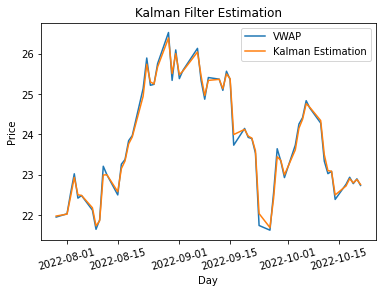

In [147]:
# Plot of the 60 days period

cal_table[['VWAP','KF_Value']].plot()
plt.title('Kalman Filter Estimation')
plt.legend(['VWAP','Kalman Estimation'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.xticks(rotation=15)
plt.show()

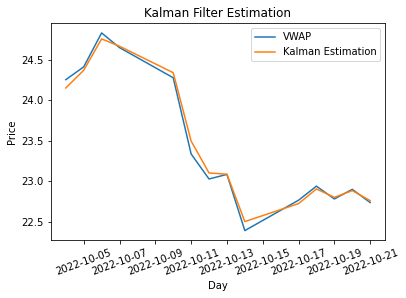

In [148]:
# Plot of two weeks

cal_table[['VWAP','KF_Value']].tail(14).plot()
plt.title('Kalman Filter Estimation')
plt.legend(['VWAP','Kalman Estimation'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.xticks(rotation=20)
plt.show()

To verify that our calculation is reasonable, we can check the percentage of the innovations that are within 1.96 standard deviation of the prediction.

In [149]:
# Percentage of the innovations that are greater than 1.65 of the standard deviation of the prediction

sum(abs(cal_table['innovation']) < 1.65*cal_table['P_predict']**0.5)/len(cal_table)

0.9166666666666666

The number is close to 90%, which is consistent with our normal distribution assumption. Our calculation is reasonable.

Since we assume that the asset value following a Brownian motion, we predict the asset value of the following four days to be the same as the last Kalman Filter estimation. Let's compare the actual VWAP of the four days and our prediction.

In [150]:
# First day of prediction

start = cal_table.index[len(cal_table)-1] + timedelta(days =1)

In [151]:
# Gather data from the first day of prediction

new_historical_data = new_historical_data.loc[new_historical_data.index.date >= start,]

In [152]:
# Impute missing prices using linear interpolation

pd.set_option('mode.chained_assignment', None)
new_historical_data['Adj Close'].interpolate(inplace=True)
new_historical_data['High'].interpolate(inplace=True)
new_historical_data['Low'].interpolate(inplace=True)
new_historical_data['Close'].interpolate(inplace=True)
new_historical_data['Volume'].fillna(0, inplace = True)

In [153]:
# Calculate the VWAP (Volume Weighted Average Price)

typical_price = (new_historical_data['High'] + new_historical_data['Low'] + new_historical_data['Close'])/3
total_traded = typical_price*new_historical_data['Volume']
total_traded.fillna(0, inplace = True)
VWAP = total_traded.groupby(total_traded.index.date).sum() / new_historical_data['Volume'].groupby(new_historical_data['Volume'].index.date).sum().replace(0,1)
VWAP = VWAP.replace(0, np.nan)

In [154]:
# Calculate the error of prediction and the number of standard deviation away from 0

prediction = cal_table['KF_Value'][len(cal_table)-1]
prediction_var = [cal_table['P'][len(cal_table)-1] + 
                  x*Q_pct * (prediction**2) for x in list(range(1,len(VWAP[asset])+1))]

pd.DataFrame({'Actual VWAP': VWAP[asset],
              'Prediction' : prediction,
              'Prediction Std' : [x**0.5 for x in prediction_var],
              'Error':VWAP[asset] - cal_table['KF_Value'][len(cal_table)-1],
              'Number of Std':(VWAP[asset] - prediction) / [x**0.5 for x in prediction_var]}).head(4)

,Actual VWAP,Prediction,Prediction Std,Error,Number of Std
2022-10-24,22.651619,22.758528,0.652024,-0.106909,-0.163965
2022-10-25,23.311725,22.758528,0.884116,0.553197,0.625706
2022-10-26,23.588834,22.758528,1.066858,0.830306,0.778272
2022-10-27,24.052763,22.758528,1.222583,1.294235,1.058607


We calculated the predicted variance increasingly by adding the Process Noise Uncertainty variance for each day. The result shows that the actual VWAP is within 1.1 standard deviation of our prediction. Our Kalman Filter calculation gives plausible predictions and can be used to manage our portfolio volatility / risk.